# deflection

## Determination of Deflection Response

The important methods used for finding out the slope and deflection at a section in a loaded beam are
1. Double integration method
2. Moment area method
3. Macaulay‟s method

With the moment-area method, the curvature diagram of a half-model according to the internal moment in Figure 1.1(c-d) is divided into several areas. By taking the moment of the areas around the left support, the mid-span deflection is obtained. A set of equations for calculating the mid-span deflection δ of the three-point and four-point bending at the first cracking (δcr), at ultimate (δu) when material has μ>μcrit are presented in Eqs.1 and qs.2. Mcr and Mu are the bending moments corresponding to the first cracking (φcr, δcr) and ultimate state (φu, δu), respectively.

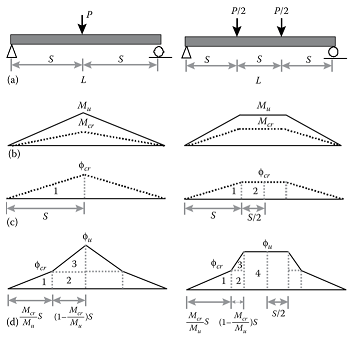

<p style="text-align: center;">figure 1.1
Moment–curvature distribution for 3PB and 4PB strain-hardening</p>


## Import modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()
from sympy import *


In [2]:
from scipy.optimize import newton, brentq, root

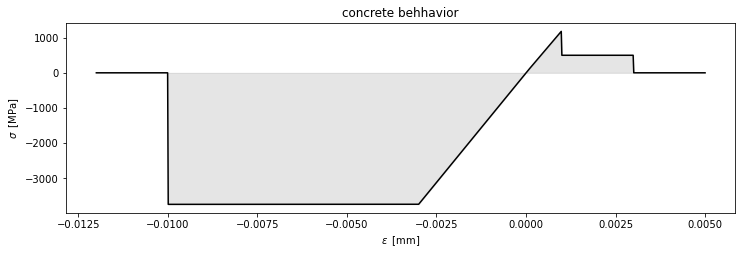

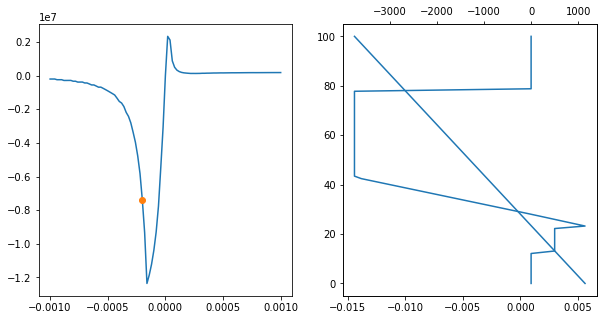

In [3]:
%run moment_curvature.ipynb

In [4]:
model_data

In [5]:
M,L ,L_p,phi,phi_u,phi_cr,M_u,M_cr,mu,mu_crit,delta_cr = sp.symbols(
    r'M,L,L_p,phi,phi_u,phi_cr,M_u,M_cr,mu,mu_crit,delta_cr', 
    real=True, nonnegative=True
)

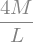

In [6]:
load = sp.Piecewise(
     (M*4/L , True ),
)
load

In [7]:
model_data = {
    phi_cr : 0.0035,
    L : 100,
    L_p : 25,
    M_cr : 25, 
    mu_crit : 0.1
}
# The values and their sign should be determind!

In [8]:
get_load = sp.lambdify(
    (M, L), load.subs(model_data), 'numpy'
)

In [9]:
load = get_load(M_arr, L)
load

array([  -8216.21363176,   -8201.63482716,   -8187.05602256,
         -9845.11064204,   -9830.53183743,   -9806.4840826 ,
        -11586.43017742,  -11556.35621088,  -11526.28224433,
        -11496.20827778,  -13429.22406674,  -13399.17830172,
        -15472.12364883,  -15418.66965142,  -15365.215654  ,
        -17562.27960492,  -17576.06600595,  -19841.63938111,
        -22289.01652267,  -22273.38647912,  -24873.80922827,
        -27591.47053249,  -27462.41899928,  -30301.24047426,
        -33249.58679311,  -36312.19282355,  -39500.40416562,
        -42772.54133164,  -46151.22509021,  -53564.43048185,
        -61426.78018064,  -65273.11323026,  -73655.78081671,
        -87575.15126979,  -97038.2499648 , -112434.51661762,
       -134722.0684912 , -158635.88593454, -191030.26156166,
       -233302.19355956, -295999.82412292, -373270.11285605,
       -494246.09033989, -474131.51968584, -448539.834408  ,
       -415282.51147479, -371690.69302319, -310243.13797875,
       -218670.3342991 ,

 Eq.1

In [ ]:
delta_3PB = sp.Piecewise(
    
    (Rational(1,12)*(L**2)*phi, phi <= phi_cr),
        ((L**2/(24*M**2))*((2*M**2-M*M_cr**2-M_cr**2)*phi + (M**2 + M*M_cr)*phi_cr) ,  phi > phi_cr),
)

delta_3PB

In [ ]:
delta_3PB.subs(model_data)

 Eq.2

In [ ]:
delta_4PB = sp.Piecewise(
    
    (Rational(23,216)*(L**2)*phi, phi <= phi_cr),
        ((L**2/(216*M**2))*((23*M**2-4*M*M_cr**2-4*M_cr**2)*phi + (4*M**2 + 4*M*M_cr)*phi_cr) ,  phi > phi_cr),
)

delta_4PB

In [ ]:
delta_4PB.subs(model_data)

In [ ]:
get_delta_3PB = sp.lambdify(
    (M, phi), delta_3PB.subs(model_data), 'numpy'
)

In [ ]:
get_delta_4PB = sp.lambdify(
    (M, phi), delta_4PB.subs(model_data), 'numpy'
)

In [ ]:
delta3PB = get_delta_3PB (M_arr, kappa_arr)
delta3PB

In [ ]:
delta4PB = get_delta_4PB (M_arr, kappa_arr)
delta4PB

In [ ]:
fig, ((ax1, ax2 , ax3)) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(kappa_arr, M_arr, 'tab:orange'),  ax1.set(title= 'Moment Curvature', xlabel=r'$\phi$', ylabel='$M$')
ax2.plot(delta3PB, load ,'tab:blue'),ax2.set(title= 'Load Deflection 3PB', xlabel=r'$\delta$', ylabel='$P$')
ax3.plot(delta4PB, load ,'tab:red'),ax3.set(title= 'Load Deflection 4PB', xlabel=r'$\delta$', ylabel='$P$')

fig. tight_layout() 
fig.autofmt_xdate()


fig, ((ax1, ax2 , ax3)) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(kappa_arr, M_arr, 'tab:orange'),  ax1.set(title= 'Moment Curvature', xlabel=r'$\phi$', ylabel='$M$')
ax2.plot(delta3PB, load ,'tab:blue'),ax2.set(title= 'Load Deflection 3PB', xlabel=r'$\delta$', ylabel='$P$')
ax3.plot(delta4PB, load ,'tab:red'),ax3.set(title= 'Load Deflection 4PB', xlabel=r'$\delta$', ylabel='$P$')

fig. tight_layout() 
fig.autofmt_xdate()


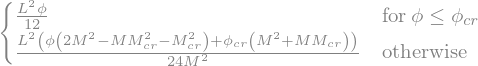

In [10]:
delta_3PB = sp.Piecewise(
    
    (Rational(1,12)*(L**2)*phi, phi <= phi_cr),
        ((L**2/(24*M**2))*((2*M**2-M*M_cr**2-M_cr**2)*phi + (M**2 + M*M_cr)*phi_cr) ,  phi > phi_cr),
)

delta_3PB

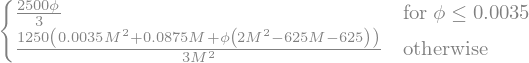

In [11]:
delta_3PB.subs(model_data)

 Eq.2

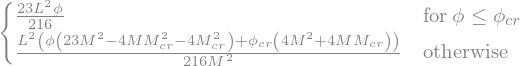

In [12]:
delta_4PB = sp.Piecewise(
    
    (Rational(23,216)*(L**2)*phi, phi <= phi_cr),
        ((L**2/(216*M**2))*((23*M**2-4*M*M_cr**2-4*M_cr**2)*phi + (4*M**2 + 4*M*M_cr)*phi_cr) ,  phi > phi_cr),
)

delta_4PB

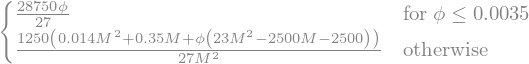

In [18]:
delta_4PB.subs(model_data)

In [19]:
get_delta_3PB = sp.lambdify(
    (M, phi), delta_3PB.subs(model_data), 'numpy'
)

In [20]:
get_delta_4PB = sp.lambdify(
    (M, phi), delta_4PB.subs(model_data), 'numpy'
)

In [21]:
delta3PB = get_delta_3PB (M_arr, kappa_arr)
delta3PB

<lambdifygenerated-7>:2: RuntimeWarning: invalid value encountered in true_divide
  return (select([less_equal(phi, 0.0035),True], [(2500/3)*phi,(1250/3)*(0.0035*M**2 + 0.0875*M + phi*(2*M**2 - 625*M - 625))/M**2], default=nan))


array([-0.83333333, -0.81666667, -0.8       , -0.78333333, -0.76666667,
       -0.75      , -0.73333333, -0.71666667, -0.7       , -0.68333333,
       -0.66666667, -0.65      , -0.63333333, -0.61666667, -0.6       ,
       -0.58333333, -0.56666667, -0.55      , -0.53333333, -0.51666667,
       -0.5       , -0.48333333, -0.46666667, -0.45      , -0.43333333,
       -0.41666667, -0.4       , -0.38333333, -0.36666667, -0.35      ,
       -0.33333333, -0.31666667, -0.3       , -0.28333333, -0.26666667,
       -0.25      , -0.23333333, -0.21666667, -0.2       , -0.18333333,
       -0.16666667, -0.15      , -0.13333333, -0.11666667, -0.1       ,
       -0.08333333, -0.06666667, -0.05      , -0.03333333, -0.01666667,
        0.        ,  0.01666667,  0.03333333,  0.05      ,  0.06666667,
        0.08333333,  0.1       ,  0.11666667,  0.13333333,  0.15      ,
        0.16666667,  0.18333333,  0.2       ,  0.21666667,  0.23333333,
        0.25      ,  0.26666667,  0.28333333,  0.3       ,  0.31

In [22]:
delta4PB = get_delta_4PB (M_arr, kappa_arr)
delta4PB

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in true_divide
  return (select([less_equal(phi, 0.0035),True], [(28750/27)*phi,(1250/27)*(0.014*M**2 + 0.35*M + phi*(23*M**2 - 2500*M - 2500))/M**2], default=nan))


array([-1.06481481, -1.04351852, -1.02222222, -1.00092593, -0.97962963,
       -0.95833333, -0.93703704, -0.91574074, -0.89444444, -0.87314815,
       -0.85185185, -0.83055556, -0.80925926, -0.78796296, -0.76666667,
       -0.74537037, -0.72407407, -0.70277778, -0.68148148, -0.66018519,
       -0.63888889, -0.61759259, -0.5962963 , -0.575     , -0.5537037 ,
       -0.53240741, -0.51111111, -0.48981481, -0.46851852, -0.44722222,
       -0.42592593, -0.40462963, -0.38333333, -0.36203704, -0.34074074,
       -0.31944444, -0.29814815, -0.27685185, -0.25555556, -0.23425926,
       -0.21296296, -0.19166667, -0.17037037, -0.14907407, -0.12777778,
       -0.10648148, -0.08518519, -0.06388889, -0.04259259, -0.0212963 ,
        0.        ,  0.0212963 ,  0.04259259,  0.06388889,  0.08518519,
        0.10648148,  0.12777778,  0.14907407,  0.17037037,  0.19166667,
        0.21296296,  0.23425926,  0.25555556,  0.27685185,  0.29814815,
        0.31944444,  0.34074074,  0.36203704,  0.38333333,  0.40

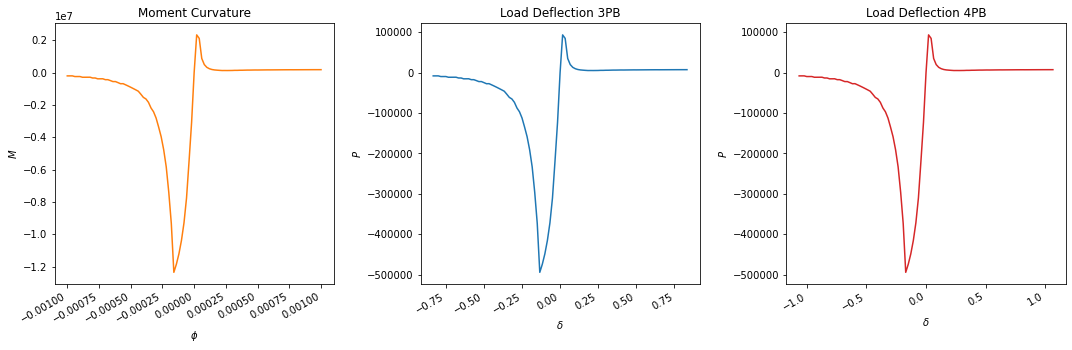

In [25]:
fig, ((ax1, ax2 , ax3)) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(kappa_arr, M_arr, 'tab:orange'),  ax1.set(title= 'Moment Curvature', xlabel=r'$\phi$', ylabel='$M$')
ax2.plot(delta3PB, load ,'tab:blue'),ax2.set(title= 'Load Deflection 3PB', xlabel=r'$\delta$', ylabel='$P$')
ax3.plot(delta4PB, load ,'tab:red'),ax3.set(title= 'Load Deflection 4PB', xlabel=r'$\delta$', ylabel='$P$')

fig. tight_layout() 
fig.autofmt_xdate()
